# Wiener Filter and LMS

This notebook walks through each filter and explains acquired results as necessary.

## Functions

### Import Dependencies

These are the packages I used throughout the notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
import os

### Utility

In [2]:
PLOT_DIR = "plots"

CSV_FILENAME = "all_results.csv"

if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

def plot_and_save(sig_true, sig_pred, figname, title="Comparison"):
    """
    Plots the true signal vs predicted, saves to figname.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(sig_true, label="Actual Output", alpha=0.7)
    plt.plot(sig_pred, label="Predicted Output", alpha=0.7)
    plt.title(title)
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, figname), dpi=150)

def plot_comparison(sig_input, sig_noisy, sig_pred, title="", max_pts=300):
    """
    Plots three signals in a single figure:
      1) Input signal
      2) Noisy/observed output
      3) Predicted output

    max_pts: number of samples to show (for clarity).
    """
    length = min(max_pts, len(sig_input), len(sig_noisy), len(sig_pred))
    plt.figure(figsize=(8,4))
    plt.plot(sig_input[:length], label="Input Signal", alpha=0.7)
    plt.plot(sig_noisy[:length], label="Noisy Output", alpha=0.7)
    plt.plot(sig_pred[:length], label="Predicted Output", alpha=0.7)
    plt.title(title)
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Signal Measurements

In [3]:
def unknown_plant(x):
    """
    H(z) = (1 - z^-10) / (1 - z^-1)
    y[n] = y[n-1] + x[n] - x[n-10].
    """
    N = len(x)
    y = np.zeros(N)
    for n in range(N):
        if n == 0:
            y[n] = x[n]
        elif n < 10:
            y[n] = y[n-1] + x[n]
        else:
            y[n] = y[n-1] + x[n] - x[n-10]
    return y

def add_noise(y, noise_var=0.1):
    """
    Add white Gaussian noise of variance = noise_var to y.
    """
    noise = np.sqrt(noise_var) * np.random.randn(len(y))
    return y + noise

def true_impulse_response(M=50):
    """
    Simulate impulse (x[0]=1, x[1..]=0) and measure the first M samples of y.
    This approximates the 'true' FIR of length M for H(z).
    """
    impulse = np.zeros(M*2)
    impulse[0] = 1.0
    h = np.zeros(M*2)
    for n in range(M*2):
        if n == 0:
            h[n] = impulse[n]
        elif n < 10:
            h[n] = h[n-1] + impulse[n]
        else:
            h[n] = h[n-1] + impulse[n] - impulse[n-10]
    return h[:M]

### Wiener Filter Calculations

In [4]:
def estimate_autocorr_matrix(x, M):
    """
    Estimate the MxM autocorrelation matrix R_xx from x.
    """
    N = len(x)
    r_xx_vec = np.zeros(M)
    for lag in range(M):
        r_xx_vec[lag] = np.sum(x[:N - lag] * x[lag:]) / (N - lag)
    R_xx = np.zeros((M, M))
    for i in range(M):
        for j in range(M):
            lag = abs(i - j)
            R_xx[i, j] = r_xx_vec[lag]
    return R_xx

def estimate_crosscorr(x, y, M):
    """
    Estimate cross-correlation vector r_xy of length M: r_xy[k] = E[x[n-k]*y[n]].
    """
    N = len(y)
    r_xy = np.zeros(M)
    for k in range(M):
        x_trunc = x[:N - k]
        y_shifted = y[k:]
        r_xy[k] = np.sum(x_trunc * y_shifted) / (N - k)
    return r_xy

def wiener_filter_solution(x, y, M, lam=0.0):
    """
    Solve Wiener filter w = (R_xx + lam*I)^-1 r_xy
    """
    R_xx = estimate_autocorr_matrix(x, M)
    r_xy = estimate_crosscorr(x, y, M)
    R_reg = R_xx + lam * np.eye(M)
    w = np.linalg.inv(R_reg).dot(r_xy)
    return w

### Normalized Least Mean Square Filter Calculations

In [5]:
def apply_nlms_filter(x_in, w_lms_k, y_noisy, mu=None, eps=None):
    """
    Applies the NLMS filter to the input signal x_in.

    x_in: input signal (M x 1)
    w_lms_k: filter weights at time k (M x 1)
    y_noisy: noisy output signal (scalar)
    mu: learning rate
    eps: regularization parameter
    """
    if mu is None:
        raise ValueError("mu must be specified.")
    if eps is None:
        raise ValueError("eps must be specified.")
    
    y_hat = np.dot(w_lms_k, x_in)
    e = y_noisy - y_hat
    x_pow  = np.dot(x_in, x_in)
    mu_eff = mu / (x_pow + eps)
    w_lms_k1 = w_lms_k + mu_eff * e * x_in

    return y_hat, w_lms_k1, mu_eff, e
def nlms_filter_full(x_in, d, M, mu, eps=1e-15):
    """
    Basic NLMS for system ID. Returns final filter after N updates.
    """
    N = len(x_in)
    x_eff = np.pad(x_in, (M, 0), mode='constant')
    x_eff = x_eff[:-1]
    y_hat = np.zeros(N)
    w_hist = np.zeros((N, M))
    mu_eff_hist = np.zeros(N)
    e_hist = np.zeros(N)
    for n in range(N):
        x_vec = x_eff[n:n+M]
        y_hat[n], w_hist[n], mu_eff_hist[n], e_hist[n] = apply_nlms_filter(x_vec, w_hist[n-1], d[n], mu, eps)
        
    return w_hist, y_hat, mu_eff_hist, e_hist

### Load Data & Constants

In [6]:
# Example parameters
model_orders = [5, 15, 50]
window_sizes = [100, 500, 5000]
lambda_candidates = [0.0, 1e-6, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1.0]

## Experiments

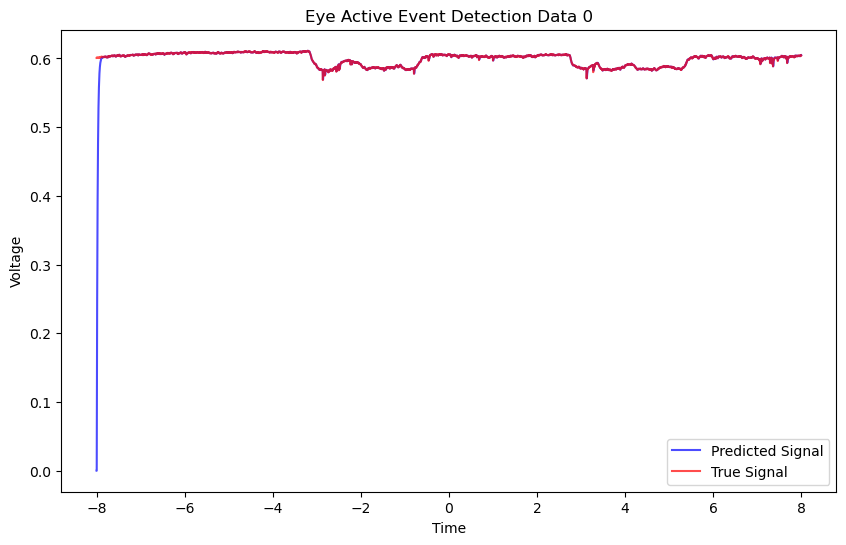

NMSE: 0.02808550607064804


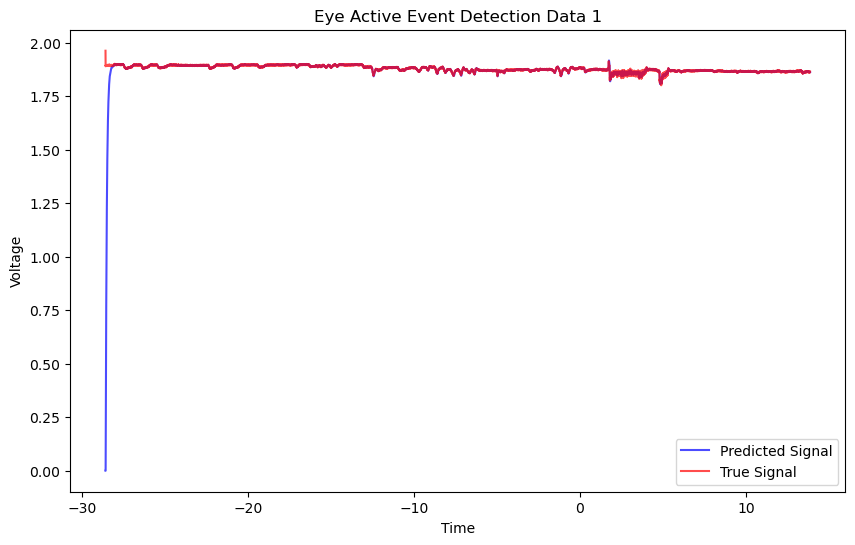

NMSE: 0.03353226120671323


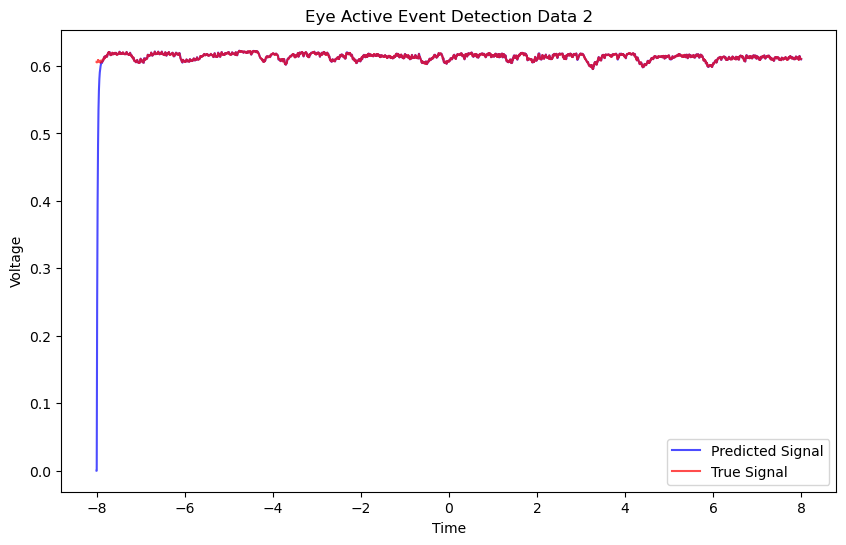

NMSE: 0.02766927696304644


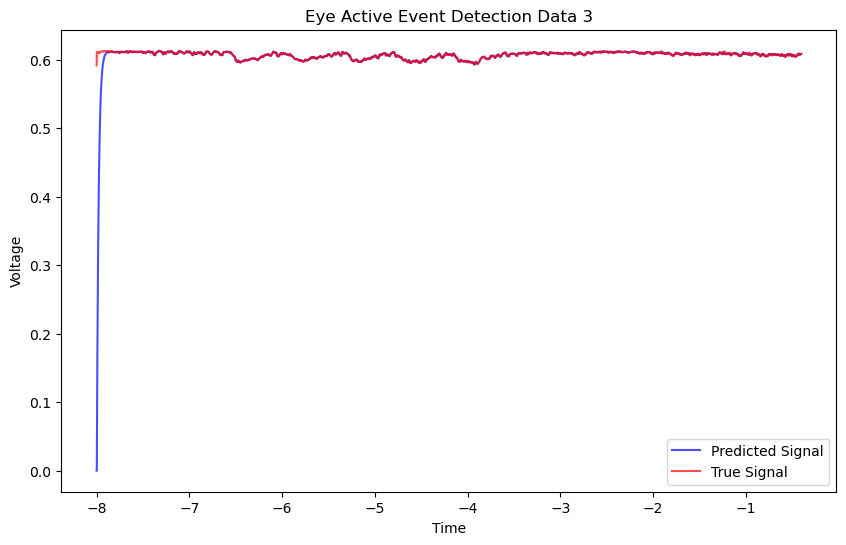

NMSE: 0.04049623054732222


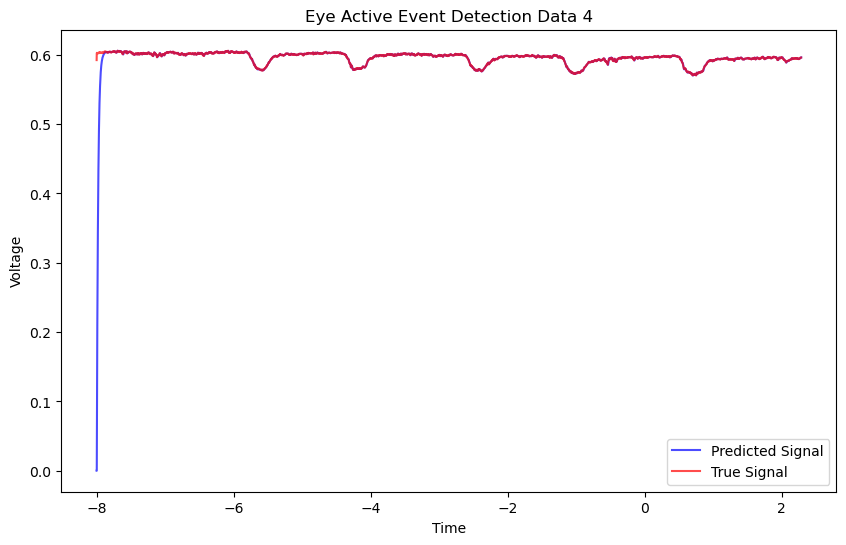

NMSE: 0.03512828069713382


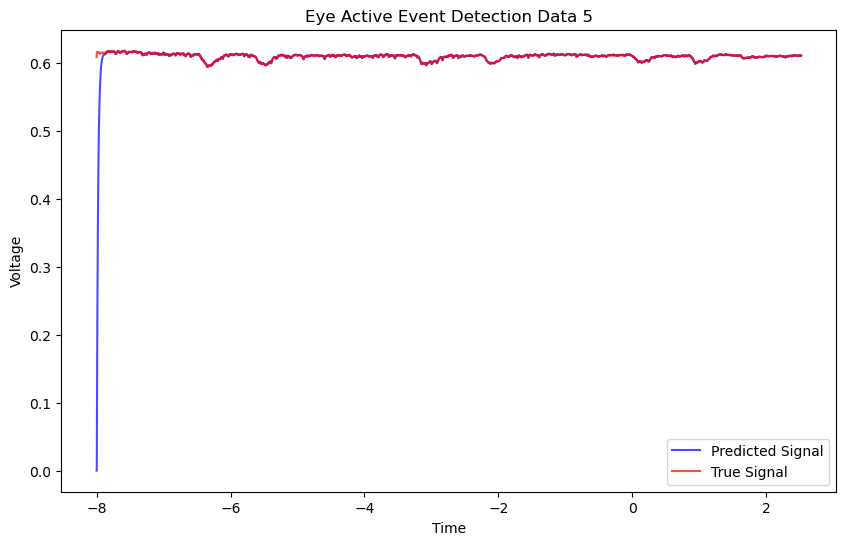

NMSE: 0.03473029956135192


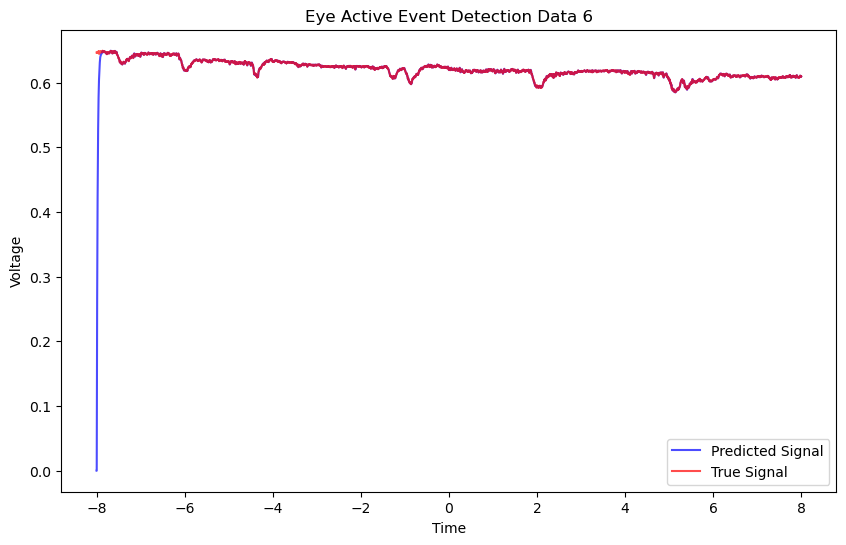

NMSE: 0.02915336306567855


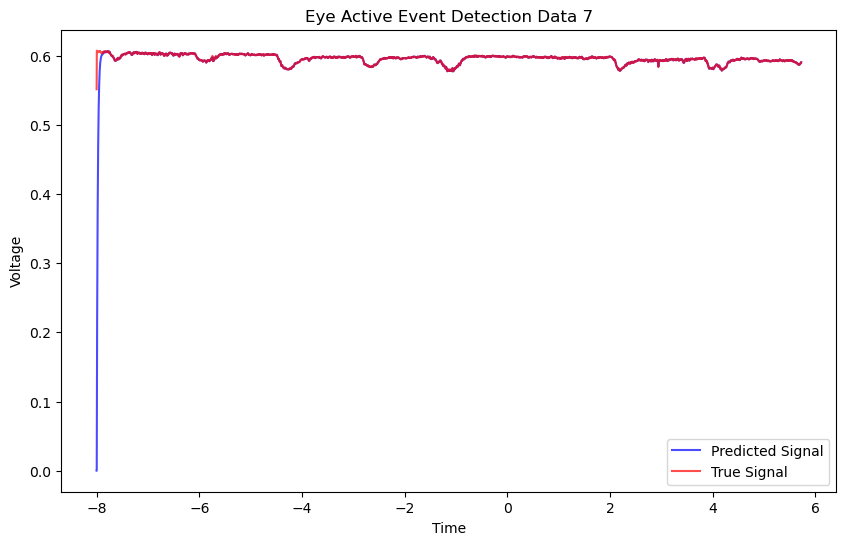

NMSE: 0.029946843919220822


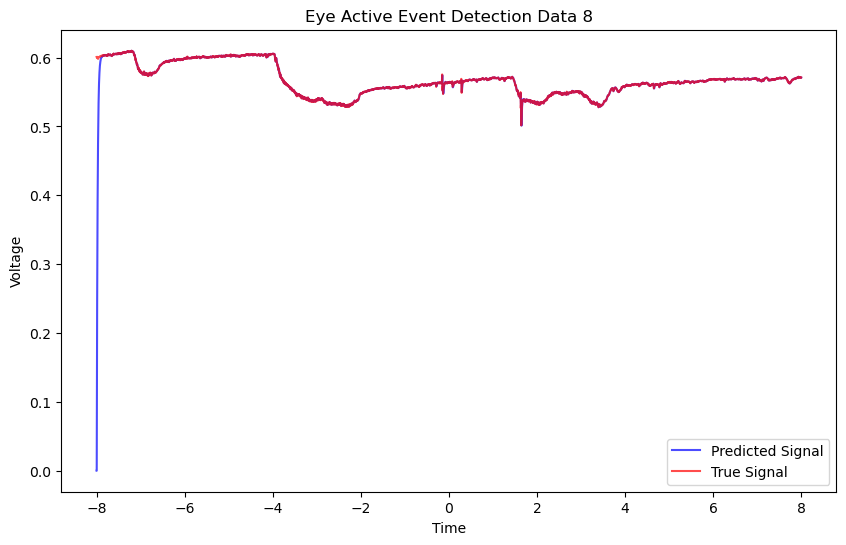

NMSE: 0.029639619309678497


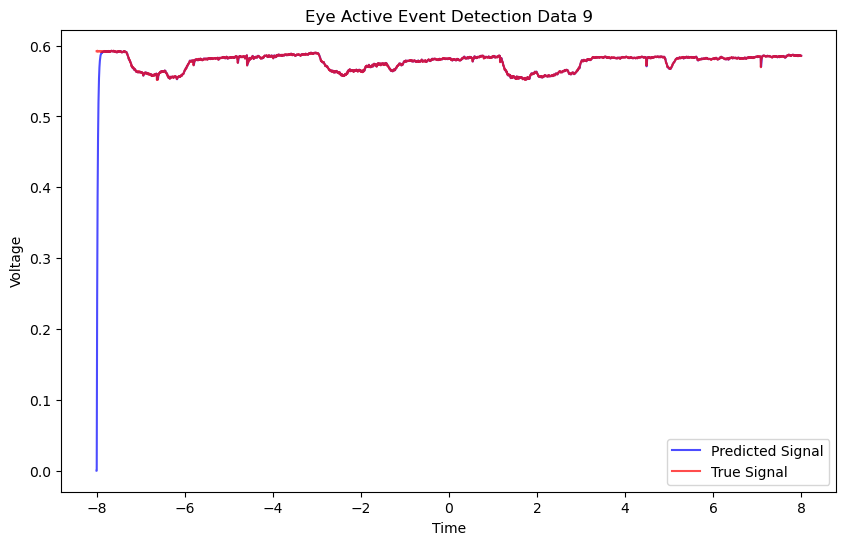

NMSE: 0.02872819009077448


In [13]:
for i in range(10):
    # Load the data
    data = pd.read_csv(f'eye_blinking{i}.csv', delimiter=',')
    # Drop Channel2
    data = data.drop(columns=['Channel2'])
    voltage = data['Channel1']
    time = data['Time']
    N = len(voltage)
    # Apply the filter
    w_hist, y_hat, mu_eff_hist, e_hist = nlms_filter_full(voltage, voltage, 4, 0.1)

    # Plot the event detection
    plt.figure(figsize=(10, 6))
    plt.plot(time, y_hat, 'b', label='Predicted Signal', alpha=0.7)
    plt.plot(time, voltage, 'r', label='True Signal', alpha=0.7)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title(f'Eye Active Event Detection Data {i}')
    plt.show()

    nmse = np.linalg.norm(e_hist) / np.linalg.norm(voltage)
    print(f'NMSE: {nmse}')